In [1]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD

In [2]:
import pandas as pd
import numpy as np

import src.dataset as dataset
import src.config as config 
from src.utils import *
import src.models as models
import src.losses as loss

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [3]:
if 'google.colab' in str(get_ipython()):
  use_colab = True
  print('Running on CoLab')
else:
  use_colab = False
  print('Not running on CoLab')

Not running on CoLab


In [4]:
if use_colab:
    # Read file from Colab Notebook
    from google.colab import drive
    drive.mount('/content/drive')
    config.MODEL_WEIGHTS = "/content/drive/My Drive/Colab Notebooks/SKADC1"
    config.IMAGE_PATH = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset/560Mhz_1000h.fits"

In [5]:
# Choose the feature extraction model
backbone='baseline_16'
# backbone='vgg16'

if backbone=='baseline_16':
    config.patch_dim = 20
    config.resizePatch = True
    config.rpn_stride = 4
    config.num_rois = 128
    # config.anchor_box_scales = [16,32,64] # anchors in the original image size
    config.anchor_box_scales = [6, 8, 12, 16, 24, 32]
    config.resizeFinalDim = 100
    input_shape_1 = config.resizeFinalDim
else:
    config.patch_dim = 100
    config.resizePatch = True
    config.rpn_stride = 16
    config.num_rois = 4
    config.resizeFinalDim = 600
    input_shape_1=config.resizeFinalDim
    config.anchor_box_scales = [32, 64, 128]


config.anchor_num = len(config.anchor_box_ratios)*len(config.anchor_box_scales)
input_shape_2=(None, 4)

print(config.resizePatch)
print(config.rpn_stride)

checkpoint = get_model_last_checkpoint(backbone)
print(f'Model last checkpoint: {checkpoint}')

True
4
Checking model checkpoints in directory /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/baseline_16
Model last checkpoint: None


Dataset shape: (19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


  0%|          | 0/19222 [00:00<?, ?it/s]

Loading FITS file /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/data/training/560Mhz_1000h.fits


100%|██████████| 19222/19222 [00:02<00:00, 6838.19it/s]


Initial dataset shape: (19222, 15)
Found 0 boxes with zero area
Rows to be deleted: 0
New dataset shape: (19222, 15)
Extending dataset with new computed columns...
Final cleaned dataset shape: (19222, 26)

Enlarging bboxes...
DONE - Enlarging bboxes...


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height,area_orig,area_cropped
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,17706.708393,19710.764566,17719.170105,6.264429,6.218255,5.734349,12.503792,12.461712,155.818657,155.818657
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,17112.270219,18509.603417,17209.564571,110.037236,44.503323,3.338082,216.538139,97.294352,21067.937901,21067.937901
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,18500.850356,16498.009965,18512.295208,5.738106,4.389739,4.827354,8.820318,11.444852,100.947234,100.947234
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18179.521298,18023.322729,18184.661968,3.031418,2.541842,6.050027,6.014593,5.140670,30.919039,30.919039
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18596.465498,18128.789688,18604.884928,4.236891,2.929772,4.869573,5.937378,8.419429,49.989332,49.989332



----------
Starting training image preprocessing...

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0065856808796525
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

Mean and stdev of the half-gaussian that best fits with noise distribution:
mu=4.561610766868865e-14, stdev=4.5037468510513567e-07
End of training image preprocessing.


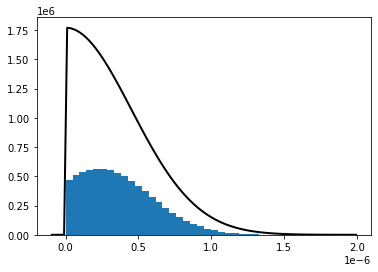

In [6]:
# Dataset parsing and loading
# use "subset" in config file to load a small portion of data for development/debugging purposes
ska_dataset = dataset.SKADataset(k=3, print_info=False, use_pb=False)

In [7]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig', 'area_cropped']].describe()

,width,height,area_orig,area_cropped
count,19222.000000,19222.000000,19222.000000,19222.000000
mean,6.282190,6.285123,44.731314,44.731314
std,3.122242,2.910949,169.529219,169.529219
min,4.964839,4.964839,24.649628,24.649628
25%,5.114121,5.116855,26.770928,26.770928
50%,5.388071,5.394034,29.928541,29.928541
75%,6.193903,6.206960,39.145862,39.145862
max,216.538139,97.294352,21067.937901,21067.937901


In [8]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig']].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99,1.])

,width,height,area_orig
0.10,5.021579,5.022318,25.628098
0.20,5.079478,5.083666,26.354817
0.30,5.153434,5.154979,27.221580
0.40,5.250224,5.256348,28.358833
0.50,5.388071,5.394034,29.928541
0.60,5.596149,5.603978,32.164977
0.70,5.931373,5.932616,36.070023
0.80,6.568193,6.603042,43.494231
0.90,8.241342,8.188366,63.754795
0.95,10.577456,10.646052,100.988437


In [9]:
# print(int(np.floor(min(ska_dataset.cleaned_train_df['x1']))))
# print(int(np.floor(min(ska_dataset.cleaned_train_df['y1']))))

In [10]:
# ska_dataset.cleaned_train_df[np.isin(ska_dataset.cleaned_train_df['ID'],[20167150, 27514971])].iloc[:,10:].head()


In [11]:
# # 16376
# # 16729

# # img_patch = ska_dataset.image_data[16729:16810,16376:16490]*10000000
# img_patch = ska_dataset.image_data[16759:16779,16436:16456]*1000000
# plt.imshow(img_patch, cmap='viridis', vmax=255, vmin=0)


In [12]:
# # 16436
# # 16779

# img_patch = ska_dataset.original_cropped_image[0:81,0:114]*1000000
# # img_patch = ska_dataset.image_data*10000000
# plt.imshow(img_patch, cmap='viridis', vmax=255, vmin=0)


In [13]:
objects_to_ignore=[20167150, 27514971]


In [14]:
# objects_to_ignore_df = ska_dataset.cleaned_train_df.loc[ska_dataset.cleaned_train_df['ID'].isin(objects_to_ignore)]
# display(objects_to_ignore_df)

In [ ]:
show_plot = True
ska_dataset.generate_patches(limit=1600, plot_patches=show_plot, objects_to_ignore=objects_to_ignore)#, source_dir='./data/training/patches')

In [16]:
ska_dataset.proc_train_df.head()

,index,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,...,x2s,y2s,class_label,patch_id,patch_name,patch_xo,patch_yo,patch_dim,bbox_w,bbox_h
0,0,13302538,-0.005224,-29.939449,-0.005224,-29.939449,0.000017,0.861438,0.076,0.076,...,16.453581,17.232278,2_2,2_16396_16729_20,560Mhz_1000h_16396_16729,16396,16729,20,4.967293,4.967293
1,1,8050427,-0.005032,-29.939239,-0.005032,-29.939239,0.000043,-0.000000,2.157,0.264,...,16.537825,19.000000,2_3,2_16396_16729_20,560Mhz_1000h_16396_16729,16396,16729,20,7.119101,7.426272
2,0,13302538,-0.005224,-29.939449,-0.005224,-29.939449,0.000017,0.861438,0.076,0.076,...,6.453581,17.232278,2_2,3_16406_16729_20,560Mhz_1000h_16406_16729,16406,16729,20,4.967293,4.967293
3,1,8050427,-0.005032,-29.939239,-0.005032,-29.939239,0.000043,-0.000000,2.157,0.264,...,6.537825,19.000000,2_3,3_16406_16729_20,560Mhz_1000h_16406_16729,16406,16729,20,6.537825,7.426272
4,0,4528448,-0.013240,-29.938728,-0.013240,-29.938728,0.000012,-0.000000,1.442,0.377,...,19.000000,19.000000,2_3,6_16436_16729_20,560Mhz_1000h_16436_16729,16436,16729,20,7.406479,2.705929


In [17]:
# ska_dataset.analyze_class_distribution()

In [18]:
# ska_dataset.split_train_val_stratified(random_state=42, val_portion=0.2)

# print(len(ska_dataset.train_patch_list))
# print(len(ska_dataset.val_patch_list))


Train list consists of 568 patches
Val list consists of 142 patches


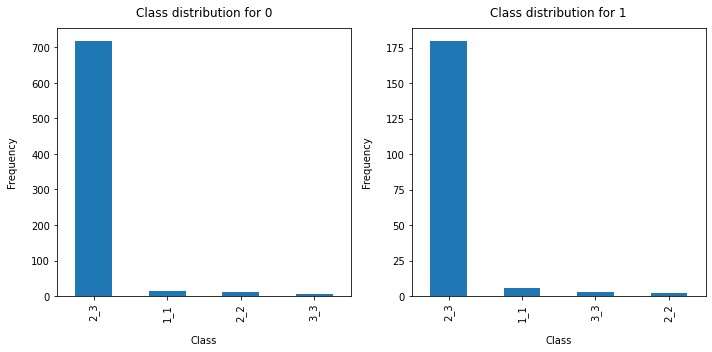

In [19]:
ska_dataset.split_train_val(random_state=42, val_portion=0.2)

## datagen + calc_rpn -> rpn_net -> rpn_to_roi -> calc_iou -> cls_net

# Training

In [20]:
# print_img(config.TRAIN_PATCHES_FOLDER, '3_16406_16729_20', show_data=True)


In [21]:
# # Debugging

# train_patch_list = ska_dataset.train_patch_list
# patches_folder_path=config.TRAIN_PATCHES_FOLDER

# train_datagen = prep.get_anchor_gt(patches_folder_path, ['20_16396_16729_20'], backbone, pixel_mean=None)
# image, [y_rpn_cls_true, y_rpn_reg_true], img_data_aug, _, _, patch_id = next(train_datagen)



### Get FRCNN model

In [22]:
# # Choose the feature extraction model
# backbone='baseline_16'
# # backbone='vgg16'

# if backbone=='baseline_16':
#     config.resizePatch = True
#     config.rpn_stride = 4
#     config.num_rois = 128
#     # config.anchor_box_scales = [16,32,64] # anchors in the original image size
#     config.anchor_box_scales = [6, 8, 12, 16, 24, 32]
#     config.resizeFinalDim = 100
#     input_shape_1 = config.resizeFinalDim
# else:
#     config.resizePatch = True
#     config.rpn_stride = 16
#     config.num_rois = 4
#     config.resizeFinalDim = 600
#     input_shape_1=config.resizeFinalDim
#     config.anchor_box_scales = [32, 64, 128]


# config.anchor_num = len(config.anchor_box_ratios)*len(config.anchor_box_scales)
# input_shape_2=(None, 4)

# print(config.resizePatch)
# print(config.rpn_stride)

# checkpoint = get_model_last_checkpoint(backbone)
# print(f'Model last checkpoint: {checkpoint}')

In [23]:
rpn_model, detector_model, total_model = models.get_train_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model.summary()
detector_model.summary()
total_model.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)    

### Load weights

In [24]:
models.load_weigths(rpn_model, detector_model, backbone, resume_train=False, checkpoint=checkpoint)
models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [25]:
# Specifically checking backbone weights

# total_model.weights[24:25][0][0][0][0]

In [26]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights): 
    # print(i,j)
    assert np.allclose(i,j), 'Weights don\'t match!'

### Train

- errore "Exception: 'a' cannot be empty unless no samples are taken" quando nel sampling ci sono meno di 4 roi
- errore "None type object is not iterable" dovuto al max(IoUs) quando calc_iou torna None, None, None, None
- patch di debug 1550_16376_16779_100
- capire il parametro classifier_regr_std in che modo influenza il training

- provare normalizzazione valori immagini di input
- provare a far passare più roi anzichè 4

In [27]:
# zzz = np.load(f'{config.TRAIN_PATCHES_FOLDER}/3100_16376_16829_100/3100_16376_16829_100.npy')

# print_img(config.TRAIN_PATCHES_FOLDER, '3100_16376_16829_100')

20_16396_16729_20

In [28]:
len(ska_dataset.train_patch_list)

568

In [41]:
from src.train import *

val_patch_list = None
# train_frcnn(rpn_model, detector_model, total_model, ['3_16406_16729_20'], val_patch_list, ska_dataset.class_list, num_epochs=100, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=True)
train_frcnn(rpn_model, detector_model, total_model, ska_dataset.train_patch_list, val_patch_list, ska_dataset.class_list, num_epochs=2500, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=True)

  0%|          | 0/6 [00:00<?, ?it/s]


Previous best loss: 2.0400591820478438
Epoch 1/2500
(100, 100)


100%|██████████| 1/1 [00:00<00:00, 10010.27it/s]


Starting rpn model training on patch 4155_16586_16989_20
Best IoU found in this run: 0.7777777561728402
Selected pos samples: 96
Selected neg samples: 32
Starting detector model training on batch
 1/10 [==>...........................] - ETA: 20s - rpn_cls: 0.6515 - rpn_regr: 0.1565 - detector_cls: 0.5629 - detector_regr: 0.5104 - average number of objects: 96.0000

  0%|          | 0/6 [00:00<?, ?it/s]

(100, 100)


100%|██████████| 1/1 [00:00<00:00, 2308.37it/s]


Starting rpn model training on patch 4459_16446_17009_20
Best IoU found in this run: 0.8749999863281253
Selected pos samples: 96
Selected neg samples: 32
Starting detector model training on batch
 2/10 [=====>........................] - ETA: 16s - rpn_cls: 0.6665 - rpn_regr: 0.1471 - detector_cls: 0.6876 - detector_regr: 0.6215 - average number of objects: 96.0000

  0%|          | 0/6 [00:00<?, ?it/s]

(100, 100)


100%|██████████| 2/2 [00:00<00:00, 28532.68it/s]


Starting rpn model training on patch 4013_16756_16979_20
Best IoU found in this run: 0.999999972222223
Selected pos samples: 96
Selected neg samples: 32
Starting detector model training on batch
 3/10 [========>.....................] - ETA: 22s - rpn_cls: 0.7478 - rpn_regr: 0.1277 - detector_cls: 0.6451 - detector_regr: 0.5826 - average number of objects: 96.0000

  0%|          | 0/6 [00:00<?, ?it/s]

(100, 100)


 50%|█████     | 3/6 [00:00<00:00,  4.08it/s]

In [31]:
total_model.save_weights(f'{config.MODEL_WEIGHTS}/{backbone}/0_frcnn_{backbone}.h5')

# Validation

In [32]:
rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)    

In [37]:
# Models used for mAP eval
cp = '23_frcnn_baseline_16.h5'
models.load_weigths(rpn_model_eval, detector_model_eval, backbone, checkpoint=cp)
models.compile_models(rpn_model_eval, detector_model_eval, total_model_eval, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [38]:
patch_id = ['3_16406_16729_20']
# patch_id = ska_dataset.train_patch_list
# print(patch_id)
# gt = pd.read_pickle(f'{config.TRAIN_PATCHES_FOLDER}/{patch_id[0]}/{patch_id[0]}.pkl')
# display(gt['class_label'])

preds, mAP, prec, recall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, patch_id, ska_dataset.class_list, metric_threshold=.5)

(100, 100)
{0: '2_2', 1: '2_3', 2: '1_1', 3: '3_3', 4: 'bg'}
Predict
rpn_to_roi
[[[0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313  0.0096769  0.23738058]
  [0.00911075 0.7340006  0.0098313 

In [ ]:
preds

In [ ]:
print(config.patch_dim , float(config.resizeFinalDim))

In [ ]:
print_img(config.TRAIN_PATCHES_FOLDER, '3_16406_16729_20')

In [39]:
anch = pd.read_pickle(f'{config.EVAL_RESULTS}/3_16406_16729_20/3_16406_16729_20.pkl')
display(anch)

,x1s,y1s,x2s,y2s,class,prob
0,0,0,0,0,2_3,0.734001
1,0,14,4,16,2_3,0.734001
2,3,14,8,16,2_3,0.734001
3,11,12,15,15,2_3,0.734001
4,0,13,2,15,2_3,0.734001
5,14,12,18,15,2_3,0.734001
6,17,12,19,14,2_3,0.734001
7,8,13,12,16,2_3,0.734001
8,1,13,5,15,2_3,0.734001
9,11,11,15,13,2_3,0.734001


In [ ]:
anch['width'] = anch['x2s'] - anch['x1s']
anch['heght'] = anch['y2s'] - anch['y1s']

In [ ]:
anch.describe() 

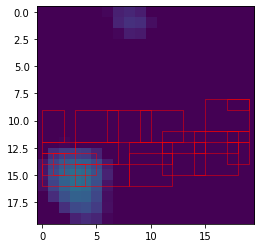

In [40]:
print_img(config.TRAIN_PATCHES_FOLDER, '3_16406_16729_20', config.EVAL_RESULTS)

TODO - 20210508:
- [X] troncamento rumore a 1e-6 tramite half gaussian

TODO - 20210605:
- [X] modificare RPNNet in modo che dia in output anche la backbone - Lorenzo
- [X] scrivere bene training loop: salvare le loss in un df su disco + salvare pesi modello ad ogni giro (Lorenzo - finire di debuggare)

TODO - 20210620:
- [x] implementare mAP in una funzione che prende come parametro un modello o i suoi pesi
- [x] implementare resNet50
- [x] implementare predicted rois - Lorenzo
- [X] implementare plot loss training - Lorenzo
- [X] finire classe datasetv2 - Alice
- [X] check se su colab le performance sono migliori - Lorenzo

TODO - 20210627
- [X] split dataset su combinazioni classi - Alice
- [x] provare campionamento random patch ed osservare le due distribuzioni - Alice

TODO - 20210703
- [x] sistemare salvataggio loss training loop - Lorenzo
- [x] Riscalare immagini tra 0-255 - Alice
- [x] capire se passare tre immagini diverse come input
- [x] usare media vgg16 per zero-centering - Alice

TODO - 20210705
- [x] sistemare nomi funzioni dataset per trasformazione rgb

TODO - 20210711
- [x] rifattorizzare classe dataset spostando nel costruttore i metodi che calcolano i suoi attributi - Lorenzo
- [x] chek valori pixel in input per resnet
- [x] fare funzione per plottare le predictions
- [ ] trainare tutto su colab

TODO - 20210714
- [x] ragionare su come scalare le immagini fra 0 e 1, attualmente hanno tanti valori schiacciati a 0 e il massimo su tutto il train a a 0.4

TODO - 20210717
- [ ] Ablation study: provare a rimuovere stage4 nella resnet - se c'è tempo
- [x] Provare con nostra pixel_mean e con vgg16 pixel_mean -> per il momento abbiamo scartato la prima opzione
- [ ] Fare qualche analisi di distribuzione delle classi/dim box del dataset - Alice
- [x] Aggiungere normalizzazione dopo zero centering per resNet50, sulla base del range globale dell'immagine di training
- [ ] Provare pulizia dataset originale sulla base del rumore/flusso - Alice
- [ ] Cambiare nomi di tutto - alla fine
- [x] implementare zero-centering su volare medio RGB delle nostre patch
- [x] Funzione che trova l'ultimo checkpoint in colab prima del load_weights - Lorenzo

TODO - 20210801
- [x] Debuggare training baseline 8 e 16 - L
- [ ] Finire prove pulizia dataseet noise variando k - A

1.  Summary
    - riassunto progetto
2.  Background
    - SoTA + teoria di base
3.  System Description
    - descrizione dei nostri modelli e dei loro componenti (moduli)
4.  Experimental setup and results
    - dataset pre processing
    - training environment
    - metrics
    - results
5.  Results and error analysis
6.  Discussion

# Plotting

In [ ]:
loss_history = np.load(f"./model/{backbone}/loss_history.npy")
print(loss_history.shape)

In [ ]:
loss_history

In [ ]:
plot_loss(loss_history)